# Init libraries

In [5]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageNet
from torchvision.transforms import ToTensor,Grayscale,Compose,RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, Resize, functional
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time as time
import numpy as np
from IPython import display

# Load Dataset and convert to grayscale

In [6]:
# Dataset class for the ImageNet dataset extending the torchvision ImageNet class
class ImageNetDataset(ImageNet):
    # Constructor
    def __init__(self, root, split='train', transform=None):
        # Calling the constructor of the parent class
        super().__init__(root, split=split, transform=transform)
        

    # Getting the image and label at a given index
    def __getitem__(self, index):
        return super().__getitem__(index)

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()

    
    

In [7]:
# Custom dataloader class for the ImageNet dataset 
class ImageNetDataLoader(DataLoader):
    # Constructor
    def __init__(self, root, batch_size, shuffle, split, transform=None):
        # Calling the constructor of the parent class
        super().__init__(ImageNetDataset(root, split=split, transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)

    # Getting the image transformed to tensor and label at a given index
    def __getitem__(self, index):
        # Getting the image and label at the given index
        image, label = self.dataset[index]
        # Transforming the image to tensor
        image = functional.to_tensor(image)
        return image, label

    # Get the grayscale image transformed to tensor and label at a given index
    def get_grayscale_image(self, index):
        # Getting the image and label at the given index
        image, label = self.dataset[index]
        # Converting the image to grayscale
        image = functional.to_grayscale(image, num_output_channels=1)
        # Transforming the image to tensor
        image = functional.to_tensor(image)
        return image, label
    

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()

In [8]:
# Define transforms
#Train transforms
train_transform = Compose([
    #ToTensor(),
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    Resize((256, 256))
])
#Test transforms
val_transform = Compose([
    Resize((256, 256))
])
# Data loaders
root="./dataset/imagenet/"
batch_size = 32
train_dataset = ImageNetDataLoader(root, batch_size, shuffle=True, split='train', transform=train_transform)
val_dataset = ImageNetDataLoader(root, batch_size, shuffle=False, split='val', transform=val_transform)

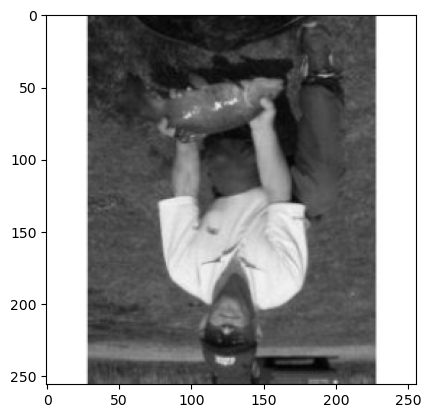

In [9]:
#Show an image from the dataset
image, label = train_dataset.get_grayscale_image(0)
plt.imshow(image[0], cmap='gray')


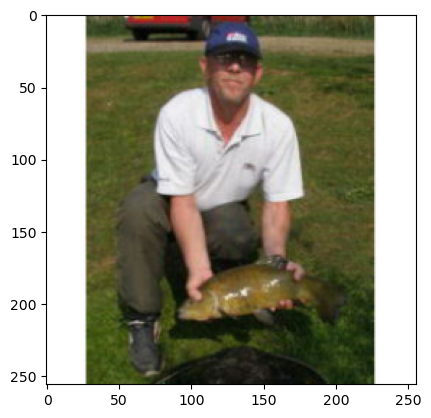

In [10]:
#Plot same image in colors
image, label = train_dataset.__getitem__(0)
plt.imshow(image.permute(1, 2, 0))

# UNET Autoencoder (Generator)
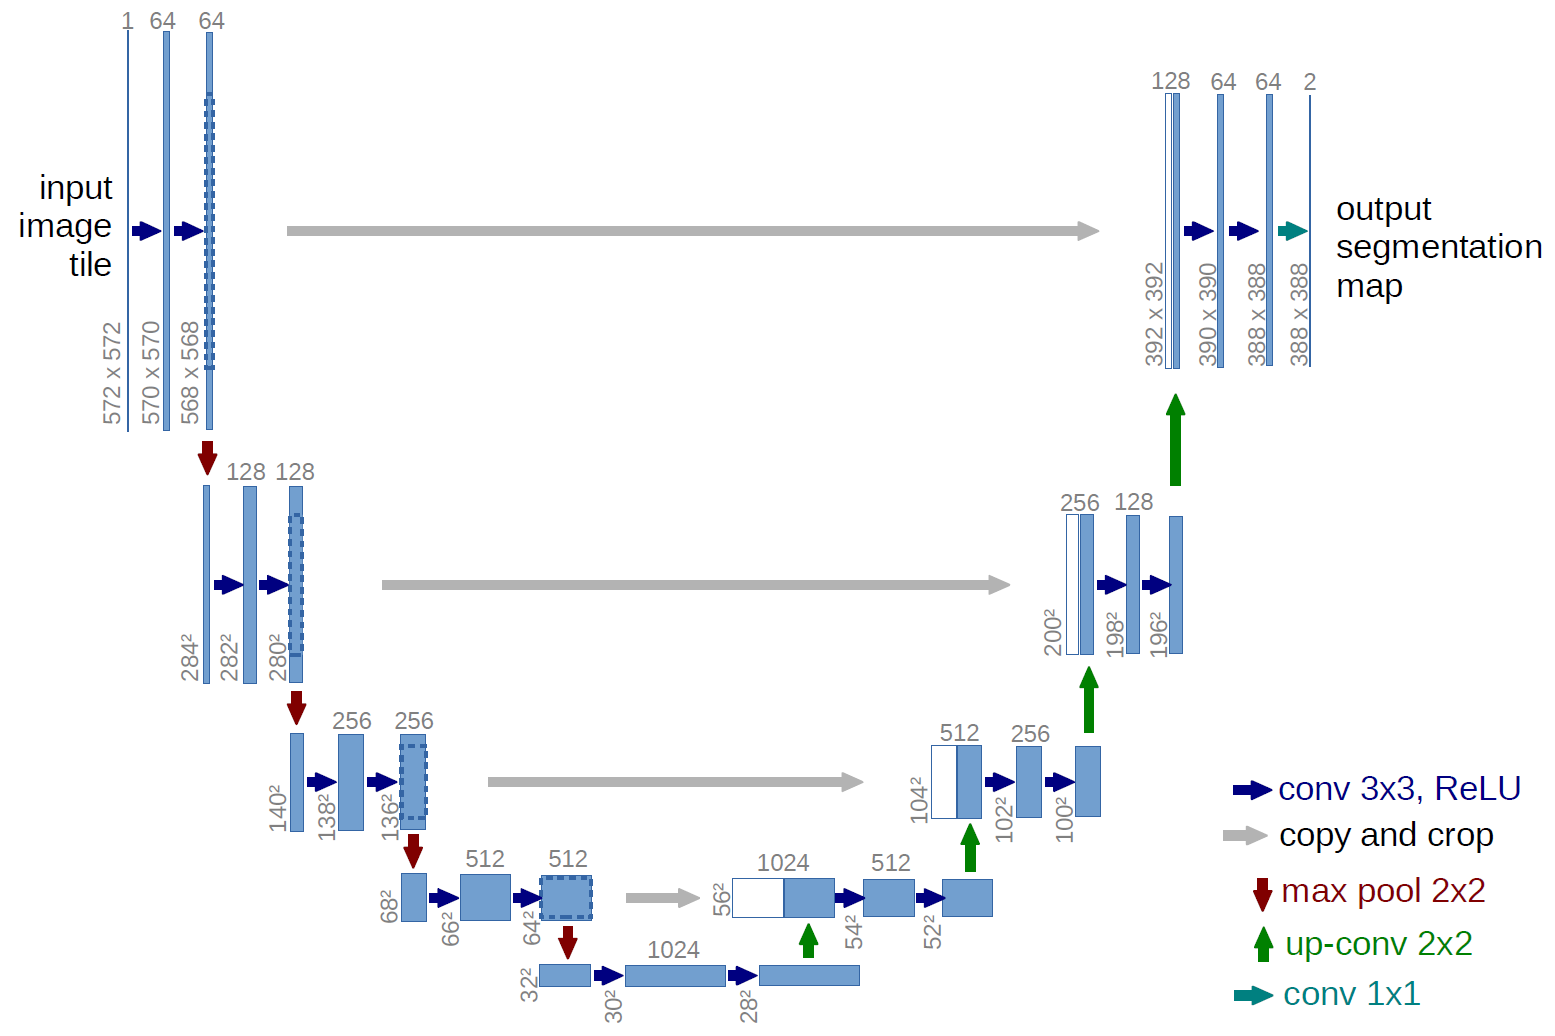

In [11]:
# Implement UNet autoencoder
class UNet(nn.Module):
    ## Constructor of the class 
    # Params:
    # in_channels= input image channels since in our case we are using grayscale images this is 1 for RGB images this would be 3
    # out_channels= outpute image channels since we want to get a colored image this is 3
    # featuress= list of numbers of output features for each block of the net (layer before max pooling) 
    # By default features are initialized like in the paper while in and out channel are already initialized how we want (can still be changed calling the constructor with different params) #
    def __init__(self, in_channels=1, out_channels=3,features=[64, 128, 256, 512]):
        super(UNet,self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder part of the network
        ## Iterate over the features list and create a double convolution block for each feature
        # after each iteration in_channels = feature since the next block in_channel is equals to the previous block output features
        # the bottom layer of the network is added later on#
        for feature in features:
            self.encoder_blocks.append(self.double_convolution(in_channels, feature))
            in_channels = feature
            # Maxpool not applied here because we need to save the output of the encoder block for the skip connection in the decoder part of the network
            
            
        # Decoder part of the network 
        # Iterate through the feature backwards (from the bottom to top of the image) #
        for feature in reversed(features):
            # Upconv part of the decoder block
            self.decoder_blocks.append(
                ## feature * 2 because the decoder block has 2 inputs 
                # (the output of the encoder block with skip connection and the output of the maxpooling of the previous decoder block)
                # kernel_size=2 and stride=2 upsample the image doubling width and height #
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
                )
            # Double convolution part of the decoder block 
            self.decoder_blocks.append(self.double_convolution(feature*2, feature))
        # Bottom layer of encoder/decoder part of the network
        # this layer is the last encoder block and first decoder block and as before uses doube convolution #
        self.bottom_layer = self.double_convolution(features[-1], features[-1]*2)
        # Final convolution layer of decoder part of the network 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    # Double convolution block utility function since both encoder and decoder have a double convolution for each block#
    def double_convolution(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            # In the 2015 paper there was no batch normalization but it should be ok to add it
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    # Forward function of the network
    # Params:
    # self=self
    # x= input image
    def forward(self, x):
        # Store the skip connections for the decoder part of the network
        skip_connections = []
        # Encoder part of the network
        # Iterate over the encoder blocks and apply them to the input image
        # add x to the skip_connections list and then apply maxpool to x
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.maxpool(x)
        
        ## Bottom layer of the network
        # Apply the bottom layer to the output of the last encoder block #
        x = self.bottom_layer(x)
        # Decoder part of the network
        # Reverse the skip connections list to iterate from the bottom layer to the top one (List have been created from top to bottom)
        skip_connections = skip_connections[::-1]
        # Iterate over the decoder blocks and apply them to the input image
        # The starting index is 0 and the step is 2 because the decoder blocks list has 2 blocks for each layer (upconv and double convolution)
        for i in range(0, len(self.decoder_blocks), 2):
            # Get the skip connection for the current layer
            skip_connection = skip_connections[i//2]
            # Apply the upconv block to the input image
            x = self.decoder_blocks[i](x)

            ## Check if the output of the upconv block and the skip connection have the same size
            # If not crop the skip connection to the size of the output of the upconv block
            # In our use case should not be necessary since we resized images to 256x256 in the dataloader #
            if x.shape != skip_connection.shape:
                skip_connection = functional.interpolate(skip_connection, size=x.shape[2:])

            # Concatenate the output of the upconv block and the skip connection
            x = torch.cat((skip_connection, x), dim=1)
            # Apply the double convolution block to the concatenated image
            x = self.decoder_blocks[i+1](x)
        
        # Final convolution layer of the network
        return self.final_conv(x)




## Quick test to see if the unet model returns an image with the same shape than the original one

In [12]:

image, label = train_dataset.get_grayscale_image(0)
x = image.unsqueeze(0)
model = UNet()  
preds = model(x)
print(x.shape)
print(preds.shape)
## expected output:
# torch.Size([1, 1, 256, 256])
# torch.Size([1, 3, 256, 256]) 
# Output shape has 3 out channels since we want to go from grayscale to RGB #




torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])


# Discriminator

In [13]:
## Define the discriminator network (PatchGAN) 
# params:
# in_channels= channels of the input image + in channels of the unet output image (3 of input image + 3 of unet output image= 6)
# features: Number of out features for each conv block (as in UNet implementation) #
class Discriminator(nn.Module):
    def __init__(self, in_channels=6, features=[64, 128, 256, 512]):
        super().__init__()
        # Define the initial convolution block of the discriminator 
        self.initial= nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        # Define the rest of the convolution blocks of the discriminator
        self.layers = nn.ModuleList()
        in_channels = features[0]
        ## Iterate over the features list and apply a conv block to each element
        # The starting index is 1 because the first element of the features list is already used in the initial block
        # Stride is 2 for all the conv blocks except the last one #
        for i in range(1, len(features)):
            # Apply a conv block to the input image
            stride=1 if features[i] == features[-1] else 2
            self.layers.append(self.conv_block(features[i-1], features[i], stride))
            in_channels = features[i]
        # Add the final convolution block to the discriminator
        self.layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))

    # Define the convolution blocks of the discriminator
    def conv_block(self, in_channels, out_channels, stride=2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding_mode="reflect", bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    ## Define the forward function of the discriminator
    # params:
    # input_image= input image
    # unet_out_image= unet output image #
    def forward(self, input_image, unet_out_image):
        # Concatenate the input image and the unet output image
        x = torch.cat([input_image, unet_out_image], dim=1)
        # Apply the initial convolution block to the concatenated image
        x = self.initial(x)
        # Apply the rest of the convolution blocks to the output of the initial block
        for layer in self.layers:
            x = layer(x)
        
        return x


## Quick test to see if discriminator works

In [14]:
# Test the discriminator network
original_image, label = train_dataset.__getitem__(0)
grayscale_image, label = train_dataset.get_grayscale_image(0)
unet = UNet()
y = unet(grayscale_image.unsqueeze(0))
disc = Discriminator()
preds = disc(original_image.unsqueeze(0), y)
print(preds.shape)

torch.Size([1, 1, 26, 26])


## Training function

In [15]:
## Implement save_checkpoint function
# params:
# model= model to save
# optimizer= optimizer to save
# filename= name of the file to save the model
# save_path= path to save the model
def save_checkpoint(model, optimizer, filename):
    state_dict = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(state_dict, filename)

## Implement WGan training loop
# params:
# epochs= number of epochs
# loader= dataloader
# gen= generator network
# disc= discriminator network
# opt_gen= optimizer for the generator network
# opt_disc= optimizer for the discriminator network
# l1= l1 loss function
# mse= mse loss function
# lambda_l1= lambda value for the l1 loss
# lambda_mse= lambda value for the mse loss
# device= device to use for training
# lambda_gp= lambda value for the gradient penalty
# n_critic= number of critic iterations
# clip_value= value to clip the discriminator weights
# lambda_gp= lambda value for the gradient penalty

def train(epochs, loader, gen, disc, opt_gen, opt_disc, l1, mse, lambda_l1, lambda_mse, device, lambda_gp=10, n_critic=5, clip_value=0.01):
    # Define the tensorboard writer
    writer = SummaryWriter(f"runs/WGAN")
    # Define the fixed input image to track the training progress
    fixed_input_image, _ = train_dataset.get_grayscale_image(0)
    fixed_input_image = fixed_input_image.unsqueeze(0).to(device)
    # Iterate over the epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        # Iterate over the batches of the dataloader
        for batch_idx, (real, _) in enumerate(loader):
            print(f"Batch {batch_idx+1}/{len(loader)}")
            # Move the batch to the device
            real = real.to(device)
            # Get the grayscale version of the batch
            grayscale = train_dataset.get_grayscale_image(batch_idx)[0].unsqueeze(0).to(device)
            # Get the unet output image
            unet_out = gen(grayscale)
            # Get the discriminator output for the unet output image
            disc_out_unet = disc(real, unet_out)
            # Get the discriminator output for the real image
            disc_out_real = disc(real, real)
            # Get the discriminator output for the fake image
            disc_out_fake = disc(real, unet_out.detach())
            # Calculate the gradient penalty
            gradient_penalty = gradient_penalty(disc, real, unet_out.detach(), device=device)
            # Calculate the discriminator loss
            disc_loss = -(torch.mean(disc_out_real) - torch.mean(disc_out_fake)) + lambda_gp * gradient_penalty
            # Train the discriminator
            disc.zero_grad()
            disc_loss.backward(retain_graph=True)
            opt_disc.step()
            # Clip the discriminator weights
            for p in disc.parameters():
                p.data.clamp_(-clip_value, clip_value)
            # Train the generator
            if batch_idx % n_critic == 0:
                # Calculate the generator loss
                gen_loss = -torch.mean(disc_out_unet)
                # Train the generator
                gen.zero_grad()
                gen_loss.backward()
                opt_gen.step()
        # Save the generator and discriminator models
        save_checkpoint(gen, opt_gen, filename=f"generator_checkpoint.pth.tar")
        save_checkpoint(disc, opt_disc, filename=f"discriminator_checkpoint.pth.tar")
        # Print the losses
        print(f"Epoch [{epoch}/{epochs}] \t Generator Loss: {gen_loss.item():.4f} \t Discriminator Loss: {disc_loss.item():.4f}")

## Training of the network

In [16]:
#Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the generator network
gen = UNet().to(device)
# Define the discriminator network
disc = Discriminator().to(device)
# Define the optimizers
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
# Define the loss functions
l1 = nn.L1Loss()
mse = nn.MSELoss()
# Train the model
train(epochs=10, loader=train_dataset, gen=gen, disc=disc, opt_gen=opt_gen, opt_disc=opt_disc, l1=l1, mse=mse, lambda_l1=100, lambda_mse=1, device=device)


Epoch 1/10


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/miniconda3/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/miniconda3/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'ImageNetDataset' on <module '__main__' (built-in)>
